# T1: Concept Drift

## Helpdesk Experiment

In [12]:
import pm4py
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from utils import *

## Preparation

In [13]:
log_path = os.path.join('..', 'data', 'full_logs', 'Helpdesk.xes')
target_dir_path = os.path.join('..', 'data', 'input_data', 'threats', 'helpdesk_two_scenarios_intermediate')
os.makedirs(target_dir_path, exist_ok=True)

In [14]:
log = pm4py.read_xes(log_path)


parsing log, completed traces :: 100%|██████████| 4580/4580 [00:00<00:00, 8925.13it/s] 


In [15]:
log.head(5)

,concept:name,lifecycle:transition,org:resource,time:timestamp,Activity,Resource,case:concept:name,case:variant,case:variant-index,case:creator
0,Assign seriousness,complete,Value 1,2012-10-09 14:50:17+00:00,Assign seriousness,Value 1,Case1,Variant 12,12,Fluxicon Disco
1,Take in charge ticket,complete,Value 1,2012-10-09 14:51:01+00:00,Take in charge ticket,Value 1,Case1,Variant 12,12,Fluxicon Disco
2,Take in charge ticket,complete,Value 2,2012-10-12 15:02:56+00:00,Take in charge ticket,Value 2,Case1,Variant 12,12,Fluxicon Disco
3,Resolve ticket,complete,Value 1,2012-10-25 11:54:26+00:00,Resolve ticket,Value 1,Case1,Variant 12,12,Fluxicon Disco
4,Closed,complete,Value 3,2012-11-09 12:54:39+00:00,Closed,Value 3,Case1,Variant 12,12,Fluxicon Disco


In [16]:
# Since simulation approaches require activity start timestamp: 
# Apply simplest heuristic of start times: set them equal to end time
log['start_timestamp'] = log['time:timestamp']
log['end_timestamp']   = log['time:timestamp']
log = log.drop('time:timestamp', axis=1)


## Investigate and display drift

#### Helper functions

In [17]:
def get_case_arrival(df, freq = 'W'):

    # Sort data by 'case:concept:name' and 'time:timestamp' to ensure the first event is at the top
    df = df.sort_values(by=['case:concept:name', 'start_timestamp'])

    # Identify the first event for each case (arriving cases)
    # This can be the first event in the sequence for each 'case:concept:name'
    arriving_cases = df.drop_duplicates(subset=['case:concept:name'], keep='first')

    # Set 'time:timestamp' as the index for resampling
    arriving_cases = arriving_cases.set_index('start_timestamp')

    # Resample and count the number of arrivals per time period
    arrival_count_resampled = arriving_cases.resample(freq).size()

    # Convert the result to a DataFrame for easier handling
    arrival_count_df = arrival_count_resampled.reset_index(name='Arrival Count')

    return arrival_count_df

arrival_count_df = get_case_arrival(log, freq = 'M')
arrival_count_df.head(2)

/var/folders/x1/w2d1_9vs4497b2lw430zv8h40000gn/T/ipykernel_44631/2072074133.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  arrival_count_resampled = arriving_cases.resample(freq).size()


,start_timestamp,Arrival Count
0,2010-01-31 00:00:00+00:00,22
1,2010-02-28 00:00:00+00:00,55


In [18]:

def plot_case_metrics(arrival_count_df, drift_time, marker_interval=4):
    # Font sizes for labels, title, ticks, and legend
    label_fontsize = 18
    title_fontsize = 20
    tick_fontsize = 16
    legend_fontsize = 16
    # figsize = (10, 4.5)
    figsize = (8, 3.5)
    linewidth = 3  
    dpi = 600

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=figsize)

    # Define the time points for training and test logs
    time_train_end = pd.Timestamp('2012-03-29 15:31:13+0000', tz='UTC')
    # time_train_end = pd.Timestamp('2011-12-13 15:31:13+0000', tz='UTC')
    time_test_post_end = pd.Timestamp('2013-11-06 10:47:35+0000', tz='UTC')

    # Light grey area to the left of the drift_time
    ax1.axvspan(arrival_count_df['start_timestamp'].min(), time_train_end, color='lightgrey', alpha=0.2)

    # Dark grey area before drift_time
    ax1.axvspan(time_train_end, drift_time + pd.Timedelta(seconds=5), color='gray', alpha=0.4)

    # Dark grey area after drift_time
    ax1.axvspan(drift_time + pd.Timedelta(seconds=5), time_test_post_end, color='gray', alpha=0.6)

    # Plot the case arrivals on the first y-axis without markers
    ax1.set_xlabel('Dates', fontsize=label_fontsize, color='black')
    ax1.set_ylabel('Case arrivals', fontsize=label_fontsize, color='black')
    arrival_line, = ax1.plot(arrival_count_df['start_timestamp'], arrival_count_df['Arrival Count'],
                             color='tab:blue', label='Case arrivals', linewidth=linewidth)

    ax1.tick_params(axis='y', labelcolor='black', labelsize=tick_fontsize)
    ax1.tick_params(axis='x', labelcolor='black', labelsize=tick_fontsize)


    # Add vertical line for drift time with the set line width
    ax1.axvline(drift_time, color='red', linestyle='--', linewidth=linewidth)  # Drift point

    # Add an arrow pointing horizontally to the drift time line with a label
    adjustment = pd.Timedelta(seconds=1) 
    ax1.annotate('Drift\npoint', 
             xy=(drift_time, ax1.get_ylim()[0] + 28),  
             xytext=(drift_time - pd.Timedelta(weeks=35), ax1.get_ylim()[0] + 28),  
             arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2),  
             fontsize=legend_fontsize, color='red', va='center', ha='right')  

    textfields_y_offset = ax1.get_ylim()[1] + 22
    # Add text fields for "Training log" and "Test log" inside the grey boxes
    ax1.text(time_train_end - pd.Timedelta(weeks=54),  
             textfields_y_offset , 
             'Training log', 
             fontsize=legend_fontsize-1, color='black', ha='center', va='center', fontweight='bold')

    ax1.text(drift_time - pd.Timedelta(weeks=10),  # Slightly before the end of the last grey box
             textfields_y_offset,  # Positioning it inside the grey box at the bottom
             'Test log\n(pre-drift)', 
             fontsize=legend_fontsize-1, color='black', ha='center', va='center', fontweight='bold')
    
    ax1.text(time_test_post_end - pd.Timedelta(weeks=28),  # Slightly before the end of the last grey box
             textfields_y_offset,  # Positioning it inside the grey box at the bottom
             'Test log\n(post-drift)', 
             fontsize=legend_fontsize-1, color='black', ha='center', va='center', fontweight='bold')

    # Enable grid for both axes:
    ax1.grid(True, axis='both')  # Horizontal and vertical grid lines for ax1

    # Set x-ticks to display every second label
    x_ticks = ax1.get_xticks()
    ax1.set_xticks(x_ticks[::2])  # Display every second tick

    fig.tight_layout()

    # Save the plot
    figure_name = 't1_help_desk.pdf'
    output_path = os.path.join('..', 'figures', figure_name)
    plt.savefig(output_path, dpi=dpi, format='pdf', bbox_inches='tight')

    plt.show()


#### Investigation

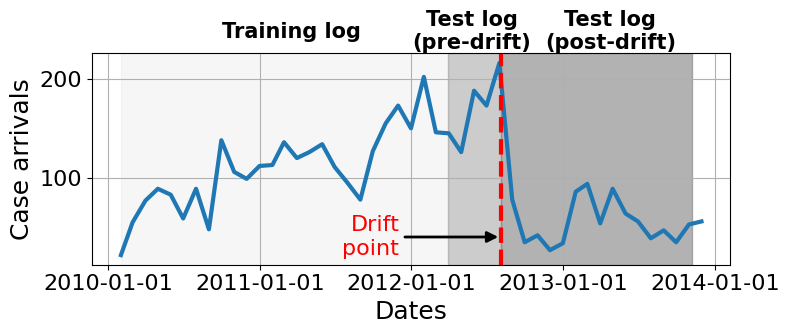

In [19]:
drift_time = pd.to_datetime('2012-08-04 00:00:00', utc=True)
plot_case_metrics(arrival_count_df, drift_time)

## Split log 
into training and test log for simulation purposes.

- (i) Pre-drift only: We split the pre-drift log into a train (80% of cases) and test
log (20%), so that we train and evaluate the model only on pre-drift data.
- (ii) Across drift: We evaluate the simulation model from scenario (i) against a
test log from the post-drift sub-log (of the same size as the test log in (i)).

In [20]:
# remove unnecessary columns from the log
log = log[['concept:name', 'org:resource', 'Activity', 'Resource', 'case:concept:name',
       'case:variant', 'case:variant-index', 'case:creator', 'start_timestamp',
       'end_timestamp']]


In [21]:
# First, split log into two sublogs by intermediate split at drift point
date_obj = pd.to_datetime('2012-08-04 00:00:00', utc=True)
criterium_value = date_obj
hd_h1, hd_h2 = intermediate_cut(log, log_ids, criterium_value, cut_criterium='timestamp', one_timestamp=False, key_timestamp=log_ids.start_time)

In [22]:
# Second, create train and test split of first sublog
# separate 80% of the cases for the training from 20% for the test log. Then remove traces that overlap the splitting point from the trianing log to keep the 20 % for testing
criterium_value = 80
hd_h1_train, hd_h1_test = intermediate_cut(hd_h1, log_ids, criterium_value, cut_criterium='nr_cases', one_timestamp=False, key_timestamp=log_ids.start_time)

In [23]:
# Nr test cases in first sublog.
nr_test_cases = hd_h1_test['case:concept:name'].nunique()
print(nr_test_cases)

# Make this as a first 
nr_cases_hd_h2 = hd_h2['case:concept:name'].nunique()
criterium_value = nr_test_cases/nr_cases_hd_h2 * 100 + 5.85
# criterium_value = nr_test_cases/nr_cases_hd_h2 * 100 + 7.593456
criterium_value 

689


86.34065420560748

In [24]:
# Third, create train and test split of first sublog
hd_h2_train, hd_h2_test = intermediate_cut(hd_h2, log_ids, criterium_value, cut_criterium='nr_cases', one_timestamp=False, key_timestamp=log_ids.start_time)

In [25]:
hd_h2_train['case:concept:name'].nunique()

690

In [26]:
write_out_logs = True
print('write_out_logs:', write_out_logs)
if write_out_logs:
    
    # Simulation scenario 1: pre-drift only
    path_h1 = os.path.join(target_dir_path, 'helpdesk_h1')
    os.makedirs(path_h1, exist_ok=True)
    hd_h1_train.to_csv( os.path.join(path_h1, 'train_log.csv'), index=False)
    hd_h1_test.to_csv(  os.path.join(path_h1, 'test_log.csv'), index=False)
    
    # Simulation scenario 2: across drift
    path_h1_2 = os.path.join(target_dir_path, 'helpdesk_h1_2')
    os.makedirs(path_h1_2, exist_ok=True)
    hd_h1_train.to_csv( os.path.join(path_h1_2, 'train_log.csv'), index=False)
    # Use the train log (the first part of h2) as test log in this simulation scenario
    hd_h2_train.to_csv(  os.path.join(path_h1_2, 'test_log.csv'),  index=False)


write_out_logs: True


### Printing AgentSimulator execution commands

In [27]:

log_name = 'helpdesk'
log_paths = ['threats/helpdesk_two_scenarios/helpdesk_h1', 'threats/helpdesk_two_scenarios/helpdesk_h1_2']
columns = {}
columns[log_name] = {
    'case_id': 'case:concept:name',
    'activity_name': 'concept:name',
    'resource_name': 'org:resource',
    'end_timestamp': 'end_timestamp',
    'start_timestamp': 'start_timestamp'
}

In [28]:
for log_path in log_paths:
    cmd =    f'''python MAS_Simulation_wucd.py \
        --train_path input_data/{log_path}/train_log.csv --test_path input_data/{log_path}/test_log.csv --case_id {columns[log_name]['case_id']} --activity_name {columns[log_name]['activity_name']} \
        --resource_name {columns[log_name]['resource_name']} --end_timestamp {columns[log_name]['end_timestamp']} --start_timestamp {columns[log_name]['start_timestamp']} \
        --warm_up_system False --cool_down_system False '''
    print(cmd)


python MAS_Simulation_wucd.py         --train_path input_data/threats/helpdesk_two_scenarios/helpdesk_h1/train_log.csv --test_path input_data/threats/helpdesk_two_scenarios/helpdesk_h1/test_log.csv --case_id case:concept:name --activity_name concept:name         --resource_name org:resource --end_timestamp end_timestamp --start_timestamp start_timestamp         --warm_up_system False --cool_down_system False 
python MAS_Simulation_wucd.py         --train_path input_data/threats/helpdesk_two_scenarios/helpdesk_h1_2/train_log.csv --test_path input_data/threats/helpdesk_two_scenarios/helpdesk_h1_2/test_log.csv --case_id case:concept:name --activity_name concept:name         --resource_name org:resource --end_timestamp end_timestamp --start_timestamp start_timestamp         --warm_up_system False --cool_down_system False 
